### Researcher Name Extraction Dataset

Dataset statistics:

| Data file  | Documents | Sentences | Tokens | Names |
|------------|-----------|-----------|--------|-------|
| Training   | 80        | 24728     | 110269 | 5822  |
| Validation | 35        | 8743      | 36757  | 1788  |
| Test       | 35        | 10399     | 44795  | 2723  |
| Total      | 145       | 43870     | 191821 | 10333 |

In [ ]:
import numpy as np
import time
import os
import random
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from optparse import OptionParser
from pathlib import Path
from model.hmm import HiddenMarkov, load_dataset

start_time = time.time()
for name in ['train', 'valid', 'test']:
    _, Y, T = load_dataset('../data/ner_on_html/' + name)
    t = [[['O', 'B-PER', 'I-PER'][t__] for t__ in t_] for t_ in Y]
    p = [[['O', 'B-PER', 'I-PER'][p__] for p__ in p_] for p_ in Y]
    w = T
    
    with Path('../results/score/{}.preds.txt'.format(name)).open('wb') as f:
        for words, preds, tags in zip(w, p, t):
            f.write(b'\n')
            for word, pred, tag in zip(words, preds, tags):
                f.write(' '.join([word, tag, pred]).encode() + b'\n')

!cd .. && ./eval.sh | grep processed

In [ ]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def plot_word_frequency(directory, color):
    my_counter = Counter()
    for fname in ['train', 'valid', 'test']:
        with open(directory + '/' + fname) as f:
            words = [line.strip().lower().split()[0] for line in f if len(line.strip()) > 0]
            words = [w for w in words if w != '-docstart-']
            my_counter.update(words)

    data = [(key, my_counter[key]) for key in my_counter]    
    data.sort(key=lambda x: x[1], reverse=True)
    
    print([(i, x[1]) for i, x in enumerate(data)][:100])
    plt.plot([x[1] for x in data][:100], color)
    return data[:50]
    
plt.title('Word frequencies')
data1 = plot_word_frequency('../data/conll2003', 'r')
data2 = plot_word_frequency('../data/ner_on_html', 'b')

print(' '.join([d[0] for d in data1[:10]]))
print()
print(' '.join([d[0] for d in data2[:10]]))

for d1, d2 in zip(data1, data2):
    print('%s & %d & %s & %d' % (d1[0], d1[1], d2[0], d2[1]))

[['department', '0', '0', '0', '0', '0', '0', '1', '0', 'head.html', 'none'], ['of', '0', '1', '0', '0', '0', '0', '0', '0', 'head.html', 'none'], ['computer', '0', '0', '0', '0', '0', '0', '1', '0', 'head.html', 'none'], ['science', '0', '0', '0', '0', '0', '0', '1', '0', 'head.html', 'none'], ['and', '0', '1', '0', '0', '0', '0', '0', '0', 'head.html', 'none']]


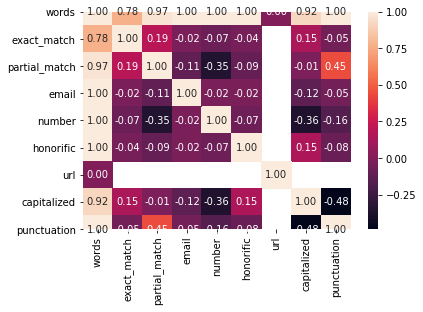

In [8]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from dython import nominal

def load_raw_dataset(f):
    with open(f, 'r', encoding='utf8') as f:
        data = f.read().strip()
        sentences = [s.split('\n') for s in data.split('\n\n') if not s.startswith('-DOCSTART-')]
        X = [t.split(' ') for s in sentences for t in s if len(s) > 0]
        for i, s in enumerate(X):
            X[i] = X[i][2:5] + X[i][7:]
        return X

X = load_raw_dataset('../data/ner_on_html/train')
X += load_raw_dataset('../data/ner_on_html/valid')
X += load_raw_dataset('../data/ner_on_html/test')
print(X[:5])

data = {}
data['words']         = [x[0 ] for x in X]
data['exact_match']   = [int(x[1]) for x in X]
data['partial_match'] = [int(x[2]) for x in X]
data['email']         = [int(x[3]) for x in X]
data['number']        = [int(x[4]) for x in X]
data['honorific']     = [int(x[5]) for x in X] 
data['url']           = [int(x[6]) for x in X]
data['capitalized']   = [int(x[7]) for x in X]
data['punctuation']   = [int(x[8]) for x in X]
# data['html_tag']      = [x[9 ] for x in X]
# data['css_class']     = [x[10] for x in X]

data['words'][0]
df = pd.DataFrame(data)

nominal.associations(df, nominal_columns=['words'])

### How to do it: https://github.com/shakedzy/dython/issues/2

Calculates Cramer's V statistic for categorical-categorical association.
Uses correction from Bergsma and Wicher, Journal of the Korean Statistical Society 42 (2013): 323-328.
This is a symmetric coefficient: V(x,y) = V(y,x)

https://github.com/shakedzy/dython/blob/master/dython/nominal.py
https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V

### Nested cross-validation

5-fold cross validation


Partition the training data randomly in five folds

Nested CV
https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html

Common error with cross validation
https://www.youtube.com/watch?v=S06JpVoNaA0

https://www.kdnuggets.com/2017/08/dataiku-predictive-model-holdout-cross-validation.html

https://www.datarobot.com/wiki/training-validation-holdout/

The dataset is split into 3 different files: train, valid, and test. Also, we provide 11 features alongside each token.

| Feature                          | Type        |
|----------------------------------|-------------|
| Unaccented lowercase token       | Categorical |
| Exact dictionary match           | Binary      |
| Partial dictionary match         | Binary      |
| Email                            | Binary      |
| Number                           | Binary      |
| Honorific (Mr., Mrs., Dr., etc.) | Binary      |
| Matches a URL                    | Binary      |
| Is capitalized                   | Binary      |
| Is a punctuation sign            | Binary      |
| HTML tag + parent                | Categorical |
| CSS class                        | Categorical |

### Hidden Markov Models

In [ ]:
import numpy as np
import time
import os
import random
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

from optparse import OptionParser
from pathlib import Path
from model.hmm import HiddenMarkov, load_dataset

def test_hmm(timesteps, use_features, dataset):
    start_time = time.time()
    naive_bayes = timesteps == 0
    if naive_bayes:
        timesteps = 1
        
    print('Fitting...')
    X1, Y1, T1 = load_dataset(dataset + '/train')
    X2, Y2, T2 = load_dataset(dataset + '/valid')
    X3, Y3, T3 = load_dataset(dataset + '/test')    
    training_set = [x for x in zip(X1 + X2 + X3, Y1 + Y2 + Y3, T1 + T2 + T3)]

    random.shuffle(training_set)
    fold_size = len(training_set) // 5
    
    folds = []
    for i in range(5):
        start = i * fold_size
        end = start + fold_size if (i < 4) else len(training_set)
        folds.append(training_set[start:end])
    print('Fold size:', fold_size)
    
    for i in range(5):
        train = []        
        for j in range(5):        
            if i != j:
                train = train + folds[j]
                
        map(list, zip(*train))
        train_X, train_Y, train_T = [list(t) for t in zip(*train)]
        
        map(list, zip(*folds[i]))
        test_X, test_Y, test_T = [list(t) for t in zip(*folds[i])]
        
        hmm = HiddenMarkov(timesteps, naive_bayes=naive_bayes, use_features=use_features, self_train=False)
        hmm.fit(train_X, train_Y)

        t = test_Y
        p = hmm.predict(test_X)

        t = [[['O', 'B-PER', 'I-PER'][t__] for t__ in t_] for t_ in t]
        p = [[['O', 'B-PER', 'I-PER'][p__] for p__ in p_] for p_ in p]
        w = test_T

        name = 'fold_' + str(i)
        print('Writing', name)
        with Path('../results/score/{}.preds.txt'.format(name)).open('wb') as f:
            for words, preds, tags in zip(w, p, t):
                f.write(b'\n')
                for word, pred, tag in zip(words, preds, tags):
                    f.write(' '.join([word, tag, pred]).encode() + b'\n')

    print('Elapsed time: %.4f' % (time.time() - start_time))

#### Naive Bayes

In [ ]:
# test_hmm(0, False, '../data/ner_on_html')

!cd .. && ./eval_model.sh
!mkdir -p ../results/cross_validation/nb
!mv ../results/score/fold* ../results/cross_validation/nb

### Maximum Entropy

In [ ]:
import numpy as np
import time
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import tensorflow as tf
from pathlib import Path
from model.estimator import Estimator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable debug logs Tensorflow.
tf.logging.set_verbosity(tf.logging.ERROR)

estimator = Estimator()
estimator.set_dataset_params({
    'datadir': '../data/ner_on_html',
    'dataset_mode': 'sentences'    
})
estimator.train_cv()
# estimator.test()

### LSTM-CRF

In [2]:
import numpy as np
import time
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import tensorflow as tf
from pathlib import Path
from model.estimator import Estimator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable debug logs Tensorflow.
tf.logging.set_verbosity(tf.logging.ERROR)

estimator = Estimator()
estimator.set_dataset_params({
    'datadir': '../data/ner_on_html',
    'dataset_mode': 'sentences',
    "model": "lstm_crf",  
    "epochs": 5,
    "batch_size": 10,
    "use_features": False,
    "word_embeddings": "elmo",
    "char_representation": "lstm",
    "decoder": "crf",  
    # "loss": "cross_entropy"
})
estimator.train_cv()

!cd .. && ./eval_model.sh
!mkdir -p ../results/cross_validation/lstm_crf_elmo
!mv ../results/score/fold* ../results/cross_validation/lstm_crf_elmo

Fold size: 29
Loss: 0.1017, Acc: 1.0000, Time: 121.6090, Step: 1000
Loss: 0.0378, Acc: 1.0000, Time: 238.9198, Step: 2000
Loss: 0.0001, Acc: 1.0000, Time: 359.0481, Step: 3000
Loss: 0.0098, Acc: 1.0000, Time: 423.8942, Step: 3553
fold_0 - Epoch 0, Precision: 0.9042, Recall: 0.9230, F1: 0.9135
Loss: 0.0124, Acc: 1.0000, Time: 63.2519, Step: 836
fold_0 - Epoch 0, Precision: 0.9511, Recall: 0.8532, F1: 0.8995
Loss: 0.0028, Acc: 1.0000, Time: 117.8207, Step: 1000
Loss: 0.0052, Acc: 1.0000, Time: 238.0059, Step: 2000
Loss: 0.0018, Acc: 1.0000, Time: 353.4686, Step: 3000
Loss: 0.0083, Acc: 1.0000, Time: 415.8655, Step: 3553
fold_0 - Epoch 1, Precision: 0.9519, Recall: 0.9579, F1: 0.9549
Loss: 0.0044, Acc: 1.0000, Time: 62.0387, Step: 836
fold_0 - Epoch 1, Precision: 0.9280, Recall: 0.8030, F1: 0.8610
Loss: 0.0006, Acc: 1.0000, Time: 117.5116, Step: 1000
Loss: 0.0777, Acc: 1.0000, Time: 236.7794, Step: 2000
Loss: 0.0996, Acc: 0.9714, Time: 354.4473, Step: 3000
Loss: 0.0013, Acc: 1.0000, Time:

Loss: 0.0643, Acc: 1.0000, Time: 123.6233, Step: 1000
Loss: 0.0293, Acc: 1.0000, Time: 245.8858, Step: 2000
Loss: 0.0194, Acc: 1.0000, Time: 367.9636, Step: 3000
Loss: 0.8547, Acc: 0.8667, Time: 418.9395, Step: 3419
fold_4 - Epoch 0, Precision: 0.8740, Recall: 0.9160, F1: 0.8945
Loss: 0.0001, Acc: 1.0000, Time: 71.9694, Step: 971
fold_4 - Epoch 0, Precision: 0.9024, Recall: 0.9431, F1: 0.9223
Loss: 0.0643, Acc: 1.0000, Time: 122.6884, Step: 1000
Loss: 0.0348, Acc: 1.0000, Time: 244.4384, Step: 2000
Loss: 0.0010, Acc: 1.0000, Time: 365.9124, Step: 3000
Loss: 0.0003, Acc: 1.0000, Time: 416.6621, Step: 3419
fold_4 - Epoch 1, Precision: 0.9523, Recall: 0.9636, F1: 0.9579
Loss: 0.0000, Acc: 1.0000, Time: 71.4247, Step: 971
fold_4 - Epoch 1, Precision: 0.9475, Recall: 0.7862, F1: 0.8593
Loss: 0.0708, Acc: 1.0000, Time: 121.0148, Step: 1000
Loss: 0.0607, Acc: 1.0000, Time: 243.3112, Step: 2000
Loss: 0.0224, Acc: 1.0000, Time: 366.4818, Step: 3000
Loss: 0.0018, Acc: 1.0000, Time: 416.9944, Ste

In [3]:
import numpy as np
import time
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import tensorflow as tf
from pathlib import Path
from model.estimator import Estimator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable debug logs Tensorflow.
tf.logging.set_verbosity(tf.logging.ERROR)

estimator = Estimator()
estimator.set_dataset_params({
    'datadir': '../data/ner_on_html',
    'dataset_mode': 'sentences',
    "model": "lstm_crf",  
    "epochs": 5,
    "batch_size": 10,
    "use_features": False,
    "word_embeddings": "glove",
    "char_representation": "lstm",
    "decoder": "crf",  
    # "loss": "cross_entropy"
})
estimator.train_cv()

!cd .. && ./eval_model.sh
!mkdir -p ../results/cross_validation/lstm_crf_elmo
!mv ../results/score/fold* ../results/cross_validation/lstm_crf_elmo

Fold size: 29
(35214, 300)
Loss: 1.2083, Acc: 0.9759, Time: 72.0324, Step: 1000
Loss: 0.0967, Acc: 1.0000, Time: 139.2430, Step: 2000
Loss: 0.6713, Acc: 0.9818, Time: 201.1569, Step: 3000
Loss: 0.0024, Acc: 1.0000, Time: 227.0417, Step: 3395
fold_0 - Epoch 0, Precision: 0.8549, Recall: 0.8824, F1: 0.8684
Loss: 0.1735, Acc: 1.0000, Time: 34.5421, Step: 995
fold_0 - Epoch 0, Precision: 0.9307, Recall: 0.9481, F1: 0.9393
Loss: 0.0007, Acc: 1.0000, Time: 70.0688, Step: 1000
Loss: 0.2897, Acc: 0.9714, Time: 137.5691, Step: 2000
Loss: 0.0082, Acc: 1.0000, Time: 201.5033, Step: 3000
Loss: 0.0026, Acc: 1.0000, Time: 225.4529, Step: 3395
fold_0 - Epoch 1, Precision: 0.9486, Recall: 0.9560, F1: 0.9523
Loss: 0.0404, Acc: 1.0000, Time: 34.5108, Step: 995
fold_0 - Epoch 1, Precision: 0.9346, Recall: 0.9527, F1: 0.9436
Loss: 0.0011, Acc: 1.0000, Time: 70.6903, Step: 1000
Loss: 0.0017, Acc: 1.0000, Time: 137.4134, Step: 2000
Loss: 0.3458, Acc: 0.9750, Time: 199.6181, Step: 3000
Loss: 0.0011, Acc: 1.0

Loss: 0.1035, Acc: 1.0000, Time: 234.7522, Step: 3537
fold_4 - Epoch 0, Precision: 0.8973, Recall: 0.9085, F1: 0.9029
Loss: 0.0011, Acc: 1.0000, Time: 27.8724, Step: 853
fold_4 - Epoch 0, Precision: 0.8271, Recall: 0.9678, F1: 0.8919
Loss: 0.0004, Acc: 1.0000, Time: 70.7192, Step: 1000
Loss: 0.0260, Acc: 1.0000, Time: 135.8408, Step: 2000
Loss: 0.1739, Acc: 0.9842, Time: 198.8692, Step: 3000
Loss: 0.0014, Acc: 1.0000, Time: 233.4605, Step: 3537
fold_4 - Epoch 1, Precision: 0.9545, Recall: 0.9620, F1: 0.9583
Loss: 0.0004, Acc: 1.0000, Time: 27.3897, Step: 853
fold_4 - Epoch 1, Precision: 0.8437, Recall: 0.9633, F1: 0.8996
Loss: 0.0004, Acc: 1.0000, Time: 72.1640, Step: 1000
Loss: 0.0015, Acc: 1.0000, Time: 136.4272, Step: 2000
Loss: 0.0060, Acc: 1.0000, Time: 198.7079, Step: 3000
Loss: 0.0009, Acc: 1.0000, Time: 233.3336, Step: 3537
fold_4 - Epoch 2, Precision: 0.9672, Recall: 0.9742, F1: 0.9707
Loss: 0.0000, Acc: 1.0000, Time: 27.4816, Step: 853
fold_4 - Epoch 2, Precision: 0.8377, Rec

In [2]:
!pip install tensorflow_hub

     |████████████████████████████████| 92kB 3.9MB/s eta 0:00:011


In [1]:
import numpy as np
import time
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import tensorflow as tf
from pathlib import Path
from model.estimator import Estimator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable debug logs Tensorflow.
tf.logging.set_verbosity(tf.logging.ERROR)

estimator = Estimator()
estimator.set_dataset_params({
    'datadir': '../data/ner_on_html',
    'dataset_mode': 'batch',
    "model": "html_attention",  
    "epochs": 5,
    "batch_size": 1,
    "use_features": False,
    "word_embeddings": "glove",
    "char_representation": "lstm",
    "decoder": "crf",  
    # "loss": "cross_entropy"
})
estimator.train_cv()

# !cd .. && ./eval_model.sh
# !mkdir -p ../results/cross_validation/hard_attention
# !mv ../results/score/fold* ../results/cross_validation/hard_attention

Fold size: 29
(35214, 300)
Loss: 1.9628, Acc: 0.9744, Time: 98.0547, Step: 1000
Loss: 2.6747, Acc: 0.9787, Time: 193.7262, Step: 2000
Loss: 0.0388, Acc: 1.0000, Time: 294.3540, Step: 3000
Loss: 0.0649, Acc: 1.0000, Time: 317.3380, Step: 3242
fold_0 - Epoch 0, Precision: 0.7888, Recall: 0.7978, F1: 0.7933
Loss: 0.1288, Acc: 1.0000, Time: 12.4614, Step: 750
fold_0 - Epoch 0, Precision: 0.8771, Recall: 0.9227, F1: 0.8993
Loss: 0.2960, Acc: 1.0000, Time: 115.3201, Step: 1000
Loss: 0.8341, Acc: 0.9828, Time: 226.1763, Step: 2000
Loss: 0.0795, Acc: 1.0000, Time: 337.5121, Step: 3000
Loss: 0.1602, Acc: 1.0000, Time: 362.9861, Step: 3242
fold_0 - Epoch 1, Precision: 0.9189, Recall: 0.9247, F1: 0.9218
Loss: 0.0850, Acc: 1.0000, Time: 12.0796, Step: 750
fold_0 - Epoch 1, Precision: 0.8820, Recall: 0.9000, F1: 0.8909
Loss: 0.0241, Acc: 1.0000, Time: 100.8367, Step: 1000
Loss: 0.0329, Acc: 1.0000, Time: 199.1742, Step: 2000
Loss: 0.5482, Acc: 1.0000, Time: 299.4331, Step: 3000
Loss: 0.0084, Acc: 1

Loss: 0.4971, Acc: 1.0000, Time: 307.8103, Step: 3260
fold_4 - Epoch 0, Precision: 0.7559, Recall: 0.7878, F1: 0.7715
Loss: 0.0005, Acc: 1.0000, Time: 13.1281, Step: 732
fold_4 - Epoch 0, Precision: 0.8590, Recall: 0.9570, F1: 0.9054
Loss: 0.3392, Acc: 1.0000, Time: 98.5181, Step: 1000
Loss: 0.1683, Acc: 1.0000, Time: 194.2214, Step: 2000
Loss: 0.2473, Acc: 1.0000, Time: 285.5459, Step: 3000
Loss: 0.1999, Acc: 1.0000, Time: 309.0835, Step: 3260
fold_4 - Epoch 1, Precision: 0.9267, Recall: 0.9306, F1: 0.9286
Loss: 0.0001, Acc: 1.0000, Time: 12.9377, Step: 732
fold_4 - Epoch 1, Precision: 0.8683, Recall: 0.9556, F1: 0.9099
Loss: 0.5255, Acc: 1.0000, Time: 95.9114, Step: 1000
Loss: 0.0238, Acc: 1.0000, Time: 191.3354, Step: 2000
Loss: 0.4579, Acc: 1.0000, Time: 290.1121, Step: 3000
Loss: 0.4949, Acc: 1.0000, Time: 315.1501, Step: 3260
fold_4 - Epoch 2, Precision: 0.9453, Recall: 0.9448, F1: 0.9451
Loss: 0.0011, Acc: 1.0000, Time: 13.4170, Step: 732
fold_4 - Epoch 2, Precision: 0.8565, Rec

In [2]:
!cd .. && ./eval_model.sh
!mkdir -p ../results/cross_validation/hard_attention
!mv ../results/score/fold* ../results/cross_validation/hard_attention

89.57%	91.10%	90.33%	93.03%	86.88%	89.85%	89.70%	89.38%	89.54%	94.28%	94.17%	94.23%	86.15%	94.48%	90.12%	91.86%	91.05%	91.45%	94.91%	86.60%	90.57%	89.96%	88.73%	89.34%	94.42%	93.91%	94.17%	86.18%	94.48%	90.14%	

In [4]:
import numpy as np
import time
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import tensorflow as tf
from pathlib import Path
from model.estimator import Estimator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable debug logs Tensorflow.
tf.logging.set_verbosity(tf.logging.ERROR)

estimator = Estimator()
estimator.set_dataset_params({
    'datadir': '../data/ner_on_html',
    'dataset_mode': 'batch',
    "model": "self_attention",  
    "epochs": 5,
    "batch_size": 1,
    "use_features": False,
    "word_embeddings": "glove",
    "char_representation": "lstm",
    "decoder": "crf",  
    # "loss": "cross_entropy"
})
estimator.train_cv()

# !cd .. && ./eval_model.sh
# !mkdir -p ../results/cross_validation/hard_attention
# !mv ../results/score/fold* ../results/cross_validation/hard_attention

Fold size: 29
(35214, 300)
Loss: 2.8710, Acc: 0.9804, Time: 145.5309, Step: 1000
Loss: 2.9154, Acc: 0.9841, Time: 278.7191, Step: 2000
Loss: 0.1704, Acc: 1.0000, Time: 410.0929, Step: 3000
Loss: 3.1611, Acc: 0.9683, Time: 448.5400, Step: 3298
fold_0 - Epoch 0, Precision: 0.7853, Recall: 0.7334, F1: 0.7585
Loss: 0.1966, Acc: 1.0000, Time: 13.4433, Step: 695
fold_0 - Epoch 0, Precision: 0.8785, Recall: 0.8316, F1: 0.8544
Loss: 0.7676, Acc: 1.0000, Time: 127.4067, Step: 1000
Loss: 0.1115, Acc: 1.0000, Time: 256.2757, Step: 2000
Loss: 0.3519, Acc: 1.0000, Time: 384.1930, Step: 3000
Loss: 0.3518, Acc: 1.0000, Time: 419.2217, Step: 3298
fold_0 - Epoch 1, Precision: 0.8883, Recall: 0.8886, F1: 0.8884
Loss: 0.8136, Acc: 1.0000, Time: 13.9908, Step: 695
fold_0 - Epoch 1, Precision: 0.8700, Recall: 0.8545, F1: 0.8622
Loss: 1.3705, Acc: 1.0000, Time: 131.3167, Step: 1000
Loss: 0.0074, Acc: 1.0000, Time: 258.5795, Step: 2000
Loss: 0.1804, Acc: 1.0000, Time: 380.0249, Step: 3000
Loss: 1.7701, Acc: 

Loss: 0.1400, Acc: 1.0000, Time: 17.1708, Step: 1000
Loss: 0.0426, Acc: 1.0000, Time: 17.4268, Step: 1017
fold_4 - Epoch 0, Precision: 0.8827, Recall: 0.9409, F1: 0.9109
Loss: 0.1817, Acc: 1.0000, Time: 128.1843, Step: 1000
Loss: 0.2908, Acc: 1.0000, Time: 246.7436, Step: 2000
Loss: 0.3685, Acc: 1.0000, Time: 359.9161, Step: 2976
fold_4 - Epoch 1, Precision: 0.8979, Recall: 0.9121, F1: 0.9050
Loss: 0.0713, Acc: 1.0000, Time: 16.5894, Step: 1000
Loss: 0.1997, Acc: 1.0000, Time: 16.8548, Step: 1017
fold_4 - Epoch 1, Precision: 0.8514, Recall: 0.9453, F1: 0.8959
Loss: 1.3602, Acc: 0.9808, Time: 121.3681, Step: 1000
Loss: 0.4690, Acc: 1.0000, Time: 238.7000, Step: 2000
Loss: 3.2894, Acc: 0.9600, Time: 353.1877, Step: 2976
fold_4 - Epoch 2, Precision: 0.9156, Recall: 0.9203, F1: 0.9180
Loss: 0.0891, Acc: 1.0000, Time: 16.9082, Step: 1000
Loss: 0.0509, Acc: 1.0000, Time: 17.1852, Step: 1017
fold_4 - Epoch 2, Precision: 0.9057, Recall: 0.9429, F1: 0.9239
Loss: 2.9725, Acc: 0.9839, Time: 124.1

In [5]:
import numpy as np
import time
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import tensorflow as tf
from pathlib import Path
from model.estimator import Estimator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable debug logs Tensorflow.
tf.logging.set_verbosity(tf.logging.ERROR)

estimator = Estimator()
estimator.set_dataset_params({
    'datadir': '../data/ner_on_html',
    'dataset_mode': 'sentences',
    "model": "maxent",  
    "epochs": 2,
    "batch_size": 10,
    "use_features": False,
    "word_embeddings": "none",
    "char_representation": "none",
    "decoder": "crf",  
    # "loss": "cross_entropy"
})
estimator.train_cv()

# !cd .. && ./eval_model.sh
# !mkdir -p ../results/cross_validation/hard_attention
# !mv ../results/score/fold* ../results/cross_validation/hard_attention

Fold size: 29
Loss: 0.4476, Acc: 0.9750, Time: 40.9480, Step: 1000
Loss: 0.6539, Acc: 0.9563, Time: 76.7476, Step: 2000
Loss: 0.2555, Acc: 1.0000, Time: 110.4496, Step: 3000
Loss: 0.0941, Acc: 1.0000, Time: 123.1724, Step: 3389
fold_0 - Epoch 0, Precision: 0.4090, Recall: 0.3734, F1: 0.3904
Loss: 0.1137, Acc: 1.0000, Time: 17.0826, Step: 999
fold_0 - Epoch 0, Precision: 0.6378, Recall: 0.6644, F1: 0.6508
Loss: 0.2650, Acc: 0.9700, Time: 40.7268, Step: 1000
Loss: 0.0236, Acc: 1.0000, Time: 77.4675, Step: 2000
Loss: 0.0064, Acc: 1.0000, Time: 112.3181, Step: 3000
Loss: 0.0589, Acc: 1.0000, Time: 125.1860, Step: 3389
fold_0 - Epoch 1, Precision: 0.9313, Recall: 0.9540, F1: 0.9425
Loss: 0.0495, Acc: 1.0000, Time: 17.2057, Step: 999
fold_0 - Epoch 1, Precision: 0.6592, Recall: 0.5996, F1: 0.6280
Writing fold_0
Loss: 0.4229, Acc: 0.9700, Time: 42.2542, Step: 1000
Loss: 0.1556, Acc: 1.0000, Time: 80.5992, Step: 2000
Loss: 0.1160, Acc: 1.0000, Time: 116.2057, Step: 3000
Loss: 0.4291, Acc: 1.00

In [6]:
!cd .. && ./eval_model.sh
!mkdir -p ../results/cross_validation/crf_no_features
!mv ../results/score/fold* ../results/cross_validation/crf_no_features

65.92%	59.96%	62.80%	65.66%	69.33%	67.44%	82.40%	62.61%	71.15%	69.02%	69.98%	69.50%	59.27%	78.08%	67.38%	74.55%	59.75%	66.33%	73.71%	72.58%	73.14%	85.68%	62.57%	72.32%	83.17%	73.13%	77.83%	65.36%	78.31%	71.25%	

In [7]:
import numpy as np
import time
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import tensorflow as tf
from pathlib import Path
from model.estimator import Estimator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable debug logs Tensorflow.
tf.logging.set_verbosity(tf.logging.ERROR)

estimator = Estimator()
estimator.set_dataset_params({
    'datadir': '../data/ner_on_html',
    'dataset_mode': 'batch',
    "model": "lstm_crf",  
    "epochs": 3,
    "batch_size": 1,
    "use_features": False,
    "word_embeddings": "glove",
    "char_representation": "lstm",
    "decoder": "logits",  
    "loss": "f1",
    "f_score_alpha": 0.1,  
})
estimator.train_cv()

!cd .. && ./eval_model.sh
!mkdir -p ../results/cross_validation/f_01
!mv ../results/score/fold* ../results/cross_validation/f_01

Fold size: 29
(35214, 300)
Loss: -0.9013, Acc: 0.9848, Time: 95.5340, Step: 1000
Loss: -0.8711, Acc: 0.9737, Time: 181.9080, Step: 2000
Loss: -0.9090, Acc: 1.0000, Time: 267.7814, Step: 3000
Loss: -0.9089, Acc: 1.0000, Time: 275.9861, Step: 3082
fold_0 - Epoch 0, Precision: 0.6881, Recall: 0.7469, F1: 0.7163
Loss: -0.0000, Acc: 1.0000, Time: 10.9029, Step: 909
fold_0 - Epoch 0, Precision: 0.8048, Recall: 0.8867, F1: 0.8437
Loss: -0.9058, Acc: 1.0000, Time: 84.5633, Step: 1000
Loss: -0.7721, Acc: 0.9773, Time: 171.6340, Step: 2000
Loss: -0.8778, Acc: 0.9623, Time: 255.0988, Step: 3000
Loss: -0.9056, Acc: 1.0000, Time: 262.4011, Step: 3082
fold_0 - Epoch 1, Precision: 0.8308, Recall: 0.8586, F1: 0.8445
Loss: -0.0000, Acc: 1.0000, Time: 9.9280, Step: 909
fold_0 - Epoch 1, Precision: 0.8225, Recall: 0.9265, F1: 0.8714
Loss: -0.8851, Acc: 0.9821, Time: 96.4785, Step: 1000
Loss: -0.8716, Acc: 0.9718, Time: 191.9247, Step: 2000
Loss: -0.0000, Acc: 1.0000, Time: 281.1797, Step: 3000
Loss: -0.9

In [8]:
import numpy as np
import time
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import tensorflow as tf
from pathlib import Path
from model.estimator import Estimator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable debug logs Tensorflow.
tf.logging.set_verbosity(tf.logging.ERROR)

estimator = Estimator()
estimator.set_dataset_params({
    'datadir': '../data/ner_on_html',
    'dataset_mode': 'batch',
    "model": "lstm_crf",  
    "epochs": 3,
    "batch_size": 1,
    "use_features": False,
    "word_embeddings": "glove",
    "char_representation": "lstm",
    "decoder": "logits",  
    "loss": "f1",
    "f_score_alpha": 0.6,  
})
estimator.train_cv()

!cd .. && ./eval_model.sh
!mkdir -p ../results/cross_validation/f_06
!mv ../results/score/fold* ../results/cross_validation/f_06

Fold size: 29
(35214, 300)
Loss: -0.5101, Acc: 0.9649, Time: 81.6209, Step: 1000
Loss: -0.5212, Acc: 0.9111, Time: 159.4853, Step: 2000
Loss: -0.6249, Acc: 1.0000, Time: 238.1862, Step: 3000
Loss: -0.6181, Acc: 1.0000, Time: 259.1383, Step: 3275
fold_0 - Epoch 0, Precision: 0.7134, Recall: 0.8638, F1: 0.7814
Loss: -0.0000, Acc: 0.8750, Time: 8.7896, Step: 716
fold_0 - Epoch 0, Precision: 0.7824, Recall: 0.9112, F1: 0.8419
Loss: -0.6250, Acc: 1.0000, Time: 80.5892, Step: 1000
Loss: -0.6250, Acc: 1.0000, Time: 157.0350, Step: 2000
Loss: -0.5756, Acc: 0.9583, Time: 234.3863, Step: 3000
Loss: -0.6241, Acc: 1.0000, Time: 255.0493, Step: 3275
fold_0 - Epoch 1, Precision: 0.8429, Recall: 0.9518, F1: 0.8940
Loss: -0.0000, Acc: 0.9375, Time: 8.7127, Step: 716
fold_0 - Epoch 1, Precision: 0.8361, Recall: 0.9059, F1: 0.8696
Loss: -0.5881, Acc: 0.9683, Time: 81.2054, Step: 1000
Loss: -0.6250, Acc: 1.0000, Time: 157.5964, Step: 2000
Loss: -0.5909, Acc: 0.9851, Time: 233.9046, Step: 3000
Loss: -0.62

In [ ]:
import numpy as np
import time
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import tensorflow as tf
from pathlib import Path
from model.estimator import Estimator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable debug logs Tensorflow.
tf.logging.set_verbosity(tf.logging.ERROR)
print('wtf')
estimator = Estimator()
estimator.set_dataset_params({
    'datadir': '../data/ner_on_html',
    'dataset_mode': 'batch',
    "model": "lstm_crf",  
    "epochs": 3,
    "batch_size": 1,
    "use_features": False,
    "word_embeddings": "glove",
    "char_representation": "lstm",
    "decoder": "logits",  
    "loss": "f1",
    "f_score_alpha": 0.7,  
})
estimator.train_cv()

print('wtf')
!cd .. && ./eval_model.sh
!mkdir -p ../results/cross_validation/f_07
!mv ../results/score/fold* ../results/cross_validation/f_07

In [ ]:
import numpy as np
import time
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import tensorflow as tf
from pathlib import Path
from model.estimator import Estimator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable debug logs Tensorflow.
tf.logging.set_verbosity(tf.logging.ERROR)

estimator = Estimator()
estimator.set_dataset_params({
    'datadir': '../data/ner_on_html',
    'dataset_mode': 'batch',
    "model": "lstm_crf",  
    "epochs": 3,
    "batch_size": 1,
    "use_features": False,
    "word_embeddings": "glove",
    "char_representation": "lstm",
    "decoder": "logits",  
    "loss": "f1",
    "f_score_alpha": 0.8,  
})
estimator.train_cv()

!cd .. && ./eval_model.sh
!mkdir -p ../results/cross_validation/f_08
!mv ../results/score/fold* ../results/cross_validation/f_08

In [ ]:
import numpy as np
import time
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))

import tensorflow as tf
from pathlib import Path
from model.estimator import Estimator

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable debug logs Tensorflow.
tf.logging.set_verbosity(tf.logging.ERROR)

estimator = Estimator()
estimator.set_dataset_params({
    'datadir': '../data/ner_on_html',
    'dataset_mode': 'batch',
    "model": "lstm_crf",  
    "epochs": 3,
    "batch_size": 1,
    "use_features": False,
    "word_embeddings": "glove",
    "char_representation": "lstm",
    "decoder": "logits",  
    "loss": "f1",
    "f_score_alpha": 0.9,  
})
estimator.train_cv()

!cd .. && ./eval_model.sh
!mkdir -p ../results/cross_validation/f_09
!mv ../results/score/fold* ../results/cross_validation/f_09

In [4]:
!pip install dython

     |████████████████████████████████| 215kB 3.7MB/s eta 0:00:01
     |████████████████████████████████| 13.1MB 5.9MB/s eta 0:00:01    |██▋                             | 1.1MB 5.9MB/s eta 0:00:03     |███▊                            | 1.5MB 5.9MB/s eta 0:00:02     |███████████████▊                | 6.4MB 5.9MB/s eta 0:00:02     |██████████████████▍             | 7.6MB 5.9MB/s eta 0:00:01
     |████████████████████████████████| 6.7MB 29.8MB/s eta 0:00:01     |█▎                              | 256kB 29.8MB/s eta 0:00:01     |██████████████▋                 | 3.0MB 29.8MB/s eta 0:00:01
     |████████████████████████████████| 25.2MB 8.7MB/s eta 0:00:01    |█████                           | 3.9MB 8.7MB/s eta 0:00:03     |█████████▎                      | 7.3MB 8.7MB/s eta 0:00:03     |██████████████████████▋         | 17.8MB 8.7MB/s eta 0:00:01��██████████████████████████▊ | 24.2MB 8.7MB/s eta 0:00:01
     |████████████████████████████████| 92kB 26.6MB/s eta 0:00:01
     |█████████████████